Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])
Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])
Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])
Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])
Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])
Relative position_h torch.Size([30, 64])
Relative position_v torch.Size([30, 64])


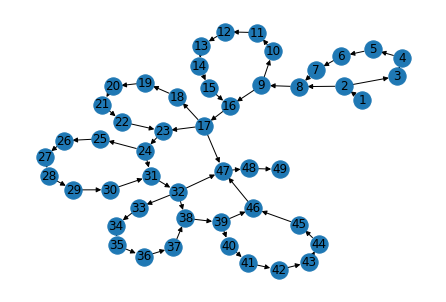

Choosing op 1 [2, 2]
Choosing op 2 [1 2]
Depth 2
Graph makrograph:
 AutoformerSearchSpace(
  (preprocess_super): Preprocess(
    (proj): Conv2d(3, 3, kernel_size=(16, 16), stride=(16, 16))
    (attn_layer_norm): LayerNormSuper((3,), eps=1e-05, elementwise_affine=True)
  )
  (attn_layer_norm): LayerNormSuper((3,), eps=1e-05, elementwise_affine=True)
  (ffn_layer_norm): LayerNormSuper((3,), eps=1e-05, elementwise_affine=True)
  (qkv_super): qkv_super(in_features=3, out_features=576, bias=False)
  (rel_pos_embed_k): RelativePosition2D_super()
  (rel_pos_embed_v): RelativePosition2D_super()
  (proj): LinearSuper(in_features=576, out_features=3, bias=True)
  (proj_drop): Dropout(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (fc1): LinearSuper(in_features=3, out_features=9, bias=True)
  (fc2): LinearSuper(in_features=9, out_features=3, bias=True)
  (norm): LayerNormSuper((768,), eps=1e-05, elementwise_affine=True)
  (head): LinearSuper(in_features=3, out_featu

<Figure size 432x288 with 0 Axes>

In [6]:
import os
import pickle
import numpy as np
import random
import itertools
import torch
import torch.nn as nn
from naslib.search_spaces.core import primitives as ops
from naslib.search_spaces.core import primitives as ops
from naslib.search_spaces.core.graph import Graph, EdgeData
from naslib.search_spaces.core.primitives import AbstractPrimitive, Identity
from naslib.search_spaces.core.query_metrics import Metric
from naslib.search_spaces.nasbench201.conversions import (
    convert_op_indices_to_naslib,
    convert_naslib_to_op_indices,
    convert_naslib_to_str,
)
import matplotlib.pyplot as plt
from naslib.utils.utils import iter_flatten, AttrDict
from model.module.preprocess import Preprocess, Preprocess_partial
from naslib.utils.utils import get_project_root
from model.module.qkv_super import qkv_super
from model.module.qkv_super import QKV_super_head_choice, LinearEmb, QKV_super_embed_choice, Dropout_emb_choice, RelativePosition2D_super, Proj_emb_choice, Dropout, AttnFfnNorm_embed_choice, Scale, LinearSuper_Emb_Ratio_Combi, Norm_embed_choice
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from model.module.Linear_super import LinearSuper
from model.module.layernorm_super import LayerNormSuper
from model.module.multihead_super import AttentionSuper
from model.utils import trunc_normal_
from model.utils import DropPath
import numpy as np


def gelu(x: torch.Tensor) -> torch.Tensor:
    if hasattr(torch.nn.functional, 'gelu'):
        return torch.nn.functional.gelu(x.float()).type_as(x)
    else:
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class AutoformerSearchSpace(Graph):
    """
    Implementation of the nasbench 201 search space.
    It also has an interface to the tabular benchmark of nasbench 201.
    """

    OPTIMIZER_SCOPE = [
        "stage_1",
        "stage_2",
        "stage_3",
    ]

    QUERYABLE = True

    def __init__(self,
                 img_size=32,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 pre_norm=True,
                 scale=False,
                 gp=False,
                 relative_position=False,
                 change_qkv=False,
                 abs_pos=True,
                 max_relative_position=14):
        super().__init__()
        self.num_classes = self.NUM_CLASSES if hasattr(self,
                                                       "NUM_CLASSES") else 10
        self.op_indices = None

        self.max_epoch = 199
        self.space_name = "autoformer"
        self.num_classes = num_classes
        self.name = "makrograph"
        # Cell is on the edges
        # 1-2:               Preprocessing
        # 2-3, ..., 6-7:     cells stage 1
        # 7-8:               residual block stride 2
        # 8-9, ..., 12-13:   cells stage 2
        # 13-14:             residual block stride 2
        # 14-15, ..., 18-19: cells stage 3
        # 19-20:             post-processing
        self.super_dropout = drop_rate
        self.super_attn_dropout = attn_drop_rate
        self.block = 0

        #
        self.choices = {
            'num_heads': [1, 2, 3],
            'mlp_ratio': [1, 2, 3],
            'embed_dim': [1, 2, 3],
            'depth': [1, 2, 3]
        }
        # operations at the edges
        #
        self.scale = scale
        self.depth_super = max(self.choices["depth"])
        self.super_num_heads = max(self.choices["num_heads"])
        self.super_head_dim = self.super_num_heads * 64 * 3
        self.super_embed_dim = max(self.choices["embed_dim"])
        self.super_mlp_ratio = max(self.choices["mlp_ratio"])
        self.super_ffn_embed_dim_this_layer = int(
            max(self.choices["mlp_ratio"]) * self.super_embed_dim)
        self.total_num_nodes = 1 + 15 * (self.depth_super) + 3
        self.add_nodes_from(range(1, self.total_num_nodes))
        self.add_edges_from([(i, i + 1)
                             for i in range(1, self.total_num_nodes)])

        self.preprocess_super = Preprocess(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim_list=self.choices["embed_dim"],
            abs_pos=abs_pos,
            pre_norm=pre_norm)
        self.attn_layer_norm = LayerNormSuper(self.super_embed_dim)
        self.ffn_layer_norm = LayerNormSuper(self.super_embed_dim)
        # preprocessing
        num_patches = self.preprocess_super.num_patches
        self.patch_emb_op_list = []
        self.pre_norm = pre_norm
        for e in self.choices["embed_dim"]:
            self.patch_emb_op_list.append(
                Preprocess_partial(self.preprocess_super, e))
        self.edges[1, 2].set("op", self.patch_emb_op_list)
        start = 2
        for i in range(self.depth_super):
            self.add_edges_from([(start, start + 6)])
            self.add_edges_from([(start + 7, start + 14)])
            start = start + 15
            if i != self.depth_super - 1 and (i + 1 in self.choices["depth"]):
                self.add_edges_from([(start, self.total_num_nodes - 2)])
                self.edges[start, self.total_num_nodes - 2].set(
                    "op", ops.Identity()
                )  #edges[start, start + 6].set("op", ops.Identity())

        start = 2
        for i in range(self.depth_super):
            self.qkv_super = qkv_super(self.super_embed_dim,
                                       3 * 64 * max(self.choices["num_heads"]),
                                       bias=qkv_bias)
            self.qkv_embed_choice_list = []
            self.attn_layer_norm = LayerNormSuper(self.super_embed_dim)
            self.ffn_layer_norm = LayerNormSuper(self.super_embed_dim)
            for e in self.choices["embed_dim"]:
                self.qkv_embed_choice_list.append(
                    QKV_super_embed_choice(self.qkv_super,
                                           self.attn_layer_norm, e,
                                           self.super_embed_dim, pre_norm))
            self.edges[start, start + 1].set("op", self.qkv_embed_choice_list)
            self.rel_pos_embed_k = RelativePosition2D_super(
                64, max_relative_position)
            self.rel_pos_embed_v = RelativePosition2D_super(
                64, max_relative_position)
            self.proj = LinearSuper(self.super_head_dim,
                                    self.super_embed_dim)
            self.qkv_head_choice_list = []
            for h in self.choices["num_heads"]:
                self.qkv_head_choice_list.append(
                    QKV_super_head_choice(self.qkv_super, self.rel_pos_embed_k,
                                          self.rel_pos_embed_v, self.proj, h,
                                          attn_drop_rate, self.super_embed_dim,
                                          self.super_head_dim))
            self.edges[start + 1, start + 2].set("op",
                                                 self.qkv_head_choice_list)
            self.proj_emb_choice_list = []
            for e in self.choices["embed_dim"]: 
                self.proj_emb_choice_list.append(
                    Proj_emb_choice(self.proj, e, self.super_embed_dim))
            self.edges[start + 2, start + 3].set("op",
                                                 self.proj_emb_choice_list)
            self.proj_drop = Dropout(drop_rate)
            self.edges[start + 3, start + 4].set("op", self.proj_drop)
            self.dropout_emb_choice_list = []
            for e in self.choices["embed_dim"]: 
                self.dropout_emb_choice_list.append(
                    Dropout_emb_choice(e, self.super_attn_dropout,
                                       self.super_embed_dim))
            self.edges[start + 4, start + 5].set("op",
                                                 self.dropout_emb_choice_list)
            dpr = [
                x.item()
                for x in torch.linspace(0, drop_path_rate, self.depth_super)
            ]
            self.drop_path = DropPath(
                dpr[0]) if dpr[0] > 0. else ops.Identity()
            self.edges[start + 5, start + 6].set("op", self.drop_path)
            self.edges[start, start + 6].set("op", ops.Identity())
            self.attn_norm_choice_list = []
            for e in self.choices["embed_dim"]: 
                self.attn_norm_choice_list.append(
                    AttnFfnNorm_embed_choice(self.attn_layer_norm,
                                             e,
                                             self.super_embed_dim,
                                             pre_norm,
                                             after=True))
            self.edges[start + 6, start + 7].set("op",
                                                 self.attn_norm_choice_list)
            self.ffn_norm_choice_list = []
            for e in self.choices["embed_dim"]:
                self.ffn_norm_choice_list.append(
                    AttnFfnNorm_embed_choice(self.ffn_layer_norm,
                                             e,
                                             self.super_embed_dim,
                                             pre_norm,
                                             before=True))
            self.edges[start + 7, start + 8].set("op",
                                                 self.ffn_norm_choice_list)
            self.fc1 = LinearSuper(
                super_in_dim=self.super_embed_dim,
                super_out_dim=self.super_ffn_embed_dim_this_layer)
            self.fc2 = LinearSuper(
                super_in_dim=self.super_ffn_embed_dim_this_layer,
                super_out_dim=self.super_embed_dim)
            self.fc1_emb_r_choice_list = []
            for e in self.choices["embed_dim"]:
                for r in self.choices["mlp_ratio"]:
                    self.fc1_emb_r_choice_list.append(
                        LinearSuper_Emb_Ratio_Combi(
                            self.fc1, self.super_ffn_embed_dim_this_layer,
                            self.super_embed_dim, self.super_mlp_ratio, e, r))
            self.edges[start + 8, start + 9].set("op",
                                                 self.fc1_emb_r_choice_list)
            self.dropout_emb_full_choice_list = []
            for e in self.choices["embed_dim"]:
                self.dropout_emb_full_choice_list.append(
                    Dropout_emb_choice(e, self.super_dropout,
                                       self.super_embed_dim))
            self.edges[start + 9, start + 10].set(
                "op", self.dropout_emb_full_choice_list)
            self.fc2_emb_r_choice_list = []
            for e in self.choices["embed_dim"]:
                for r in self.choices["mlp_ratio"]:
                    self.fc2_emb_r_choice_list.append(
                        LinearSuper_Emb_Ratio_Combi(
                            self.fc2,
                            self.super_ffn_embed_dim_this_layer,
                            self.super_embed_dim,
                            self.super_mlp_ratio,
                            e,
                            r,
                            reverse=True,
                            scale=True))
            self.edges[start + 10, start + 11].set("op",
                                                   self.fc2_emb_r_choice_list)
            self.edges[start + 11, start + 12].set(
                "op", self.dropout_emb_full_choice_list)
            self.scale_choice_list = []
            for e in self.choices["embed_dim"]:
                for r in self.choices["mlp_ratio"]:
                    self.scale_choice_list.append(
                        Scale(self.super_mlp_ratio, self.super_embed_dim, r,
                              e))
            if scale == True:
                self.edges[start + 12, start + 13].set("op",
                                                       self.scale_choice_list)
            else:
                self.edges[start + 12, start + 13].set("op", ops.Identity())
            self.edges[start + 13, start + 14].set("op", self.drop_path)
            self.edges[start + 7, start + 14].set("op", ops.Identity())
            self.ffn_norm_choice_list_after = []
            for e in self.choices["embed_dim"]:
                self.ffn_norm_choice_list_after.append(
                    AttnFfnNorm_embed_choice(self.ffn_layer_norm,
                                             e,
                                             self.super_embed_dim,
                                             pre_norm,
                                             after=True))
            self.edges[start + 14, start + 15].set(
                "op", self.ffn_norm_choice_list_after)
            start = start + 15

        if self.pre_norm:
            self.norm = LayerNormSuper(super_embed_dim=embed_dim)
            self.norm_choice_list = []
            for e in self.choices["embed_dim"]: #G2
                self.norm_choice_list.append(
                Norm_embed_choice(self.norm, e, self.super_embed_dim))
            self.edges[start, start + 1].set("op", self.norm_choice_list)
        else:
            self.edges[start, start+1].set("op", ops.Identity())
        self.head = LinearSuper(self.super_embed_dim, num_classes) if num_classes > 0 else ops.Identity()
        self.head_choice_list = []
        if num_classes > 0:
            for e in self.choices["embed_dim"]: #G2

                self.head_choice_list.append(
                    LinearEmb(self.head, e, num_classes))
            self.edges[start + 1, start + 2].set("op", self.head_choice_list)
        else:
            self.edges[start + 1, start + 2].set("op", ops.Identity())

    def sample_random_architecture(self, dataset_api=None):
        """
        This will sample a random architecture and update the edges in the
        naslib object accordingly.
        """
        op_indices_depth = np.random.randint(3, size=(1))
        depth = self.choices["depth"][op_indices_depth[0]]
        op_indices_emb = np.random.randint(3, size=(1))
        op_indices_emb = [op_indices_emb[0] for _ in range(depth)]
        op_indices_head = np.random.randint(3, size=(depth))
        op_indices_ratio_emb = np.random.randint(9, size=(depth))
        print("Choosing op 1", op_indices_emb)
        print("Choosing op 2", op_indices_head)
        print("Depth", depth)
        self.set_op_indices(op_indices_emb, op_indices_head,
                            op_indices_ratio_emb, depth)

    def set_op_indices(self, op_indices_emb, op_indices_head,
                       op_indices_ratio_emb, depth):
        # This will update the edges in the naslib object to op_indices
        self.edges[1, 2].set("op", self.patch_emb_op_list[op_indices_emb[0]])
        start = 2
        for i in range(depth):
            self.edges[start, start + 1].set(
                "op", self.qkv_embed_choice_list[op_indices_emb[i]])
            self.edges[start + 1, start + 2].set(
                "op", self.qkv_head_choice_list[op_indices_head[i]])
            self.edges[start + 2, start + 3].set(
                "op", self.proj_emb_choice_list[op_indices_emb[i]])
            self.edges[start + 4, start + 5].set(
                "op", self.dropout_emb_choice_list[op_indices_emb[i]])
            self.edges[start + 6, start + 7].set(
                "op", self.attn_norm_choice_list[op_indices_emb[i]])
            self.edges[start + 7, start + 8].set(
                "op", self.ffn_norm_choice_list[op_indices_emb[i]])
            self.edges[start + 8, start + 9].set(
                "op", self.fc1_emb_r_choice_list[op_indices_ratio_emb[i]])
            self.edges[start + 9, start + 10].set(
                "op", self.dropout_emb_full_choice_list[op_indices_emb[i]])
            self.edges[start + 10, start + 11].set(
                "op", self.fc2_emb_r_choice_list[op_indices_ratio_emb[i]])
            self.edges[start + 11, start + 12].set(
                "op", self.dropout_emb_full_choice_list[op_indices_emb[i]])
            if self.scale == True:
                self.edges[start + 12, start + 13].set(
                    "op", self.scale_choice_list[op_indices_ratio_emb[i]])
            self.edges[start + 14, start + 15].set(
                "op", self.ffn_norm_choice_list_after[op_indices_emb[i]])
            start = start + 15
        for i in range(start, self.total_num_nodes - 2):
            self.edges[i, i + 1].set("op", ops.Identity())
        start = self.total_num_nodes - 2
        if self.pre_norm:
            self.edges[start, start + 1].set("op", self.norm_choice_list[op_indices_emb[-1]])
        if self.num_classes>0:
            self.edges[start + 1, start + 2].set("op", self.head_choice_list[op_indices_emb[-1]])


def count_parameters_in_MB(model):
    return np.sum(
        np.prod(v.size()) for name, v in model.named_parameters()
        if "auxiliary" not in name) / 1e6


ss = AutoformerSearchSpace()
import networkx as nx
nx.draw(ss, with_labels=True, pos=nx.kamada_kawai_layout(ss))
plt.show()
plt.savefig('autoformer.png')
for i in range(2):
    ss.sample_random_architecture()
    ss.parse()
    print(ss.modules_str())
    #print(ss.config)
    inp = torch.randn([2, 3, 32, 32])
    out = ss(inp)
    loss = torch.sum(out)
    print(out.shape)
    #print(out)
    loss.backward()